In [2]:
import random 
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pyplot as plt

# Week 4 
Author: Adam Stewart

In this tutorial, our goals are to: implement Fast Fourier Transformation (FFT) and Random Number Generator (RNG). We will use Python's in-built 'random' module, which can generate pseudo-random data. To perform discrete FFT we will use scipy. Refer to the documentation.

https://docs.scipy.org/doc/scipy/tutorial/fft.html
https://docs.python.org/3/library/random.html

## 1-D Discrete Fourier Transform
The discrete Fourier transformation $F(x)$ a sequence of samples $x_n$ taken at discrete steps in time with equal spacing $\Delta t$. 

$$ F_k = \sum_{n=0}^{N-1} x_n e^{-2\pi \frac{k}{N} n}  $$
$$t_{n+1} - t_{n} = \Delta t$$

The sampling rate, i.e. the rate at which the data is sampled is $1/\Delta t$ (cycles/second). To measure a signal effectively, we need to have a sampling frequency that is twice the highest (Nyquist) frequency of our information. For example, audio such as vinyls and digital should be have a sample frequency twice that which can be heard by our ears. If the upper limit of human hearing is ~$20 \text{ kHz}$ (the Nyquist frequency), then the sample frequency should be greater than ~$40 \text{ kHz}$ ($2\times f_\text{Nyquist}$), so that we can hear all the information. In fact, the sample frequency for high-quality lossless audio on CDs and Vinyl is $44.1 \text{ kHz}$.

### Example 1: Generate Noisy Periodic Function

The goal here is to generate a function of two sine waves and add random Gaussian noise.  

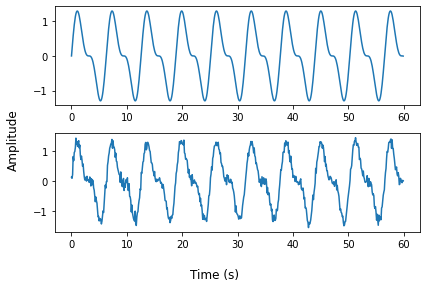

In [3]:
dt = 0.1 # 10 (ms)
sample_rate = 1/dt # sample rate (Hz)

t = np.arange(0,60,dt)
x = np.sin(t) + np.sin(2*t)*0.5
x_noise = [random.gauss(mu=0,sigma=0.1)+ x for x in x]

s = [x, x_noise]

fig, axes = plt.subplots(nrows=2,ncols=1)

for i, ax in enumerate(axes):
    ax.plot(t,s[i])

fig.supylabel('Amplitude')
fig.supxlabel('Time (s)')
fig.tight_layout()

### Example 2: FFT

Now we perform discrete FFT, implement a window function and extract the peak frequencies in the data.

Peak found at 1.67e-01 Hz
Peak found at 3.17e-01 Hz


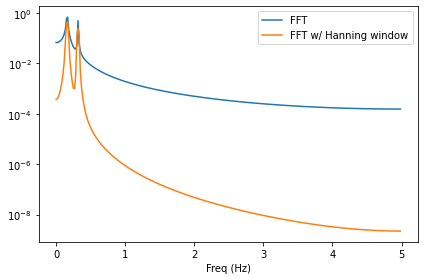

In [4]:
fft_x = fft(x)
t_fft = fftfreq(len(t), dt)[:len(t)//2]
mod_F = abs(fft_x[0:len(t)//2])/len(t_fft)

# now with Hanning window
hann = signal.hann(len(t))
fft_x_hann = fft(x*hann)
mod_F_hann = abs(fft_x_hann[0:len(t)//2])/len(t_fft)

fig, axes = plt.subplots(1)

axes.semilogy(t_fft, mod_F, label = 'FFT')
axes.semilogy(t_fft, mod_F_hann, label = 'FFT w/ Hanning window')
axes.set_xlabel('Freq (Hz)')
axes.legend()
fig.tight_layout()

peaks = signal.find_peaks(mod_F)
peak_freqs = t_fft[peaks[0]]
for freq in peak_freqs:
    print('Peak found at {:.2e} Hz'.format(freq))

### Problem 1: Normal Distribution
A Gaussian distribution $f(x)$ takes the form $$ f(x) \propto e^{-\frac{x-\mu}{2\sigma^2}}$$

Generate one thousand random data points taken from a Gaussian distribution using the Python random module. Create a histogram of the data and perform a curve fit with scipy to recover the mean $\mu$ and standard deviation $\sigma$.



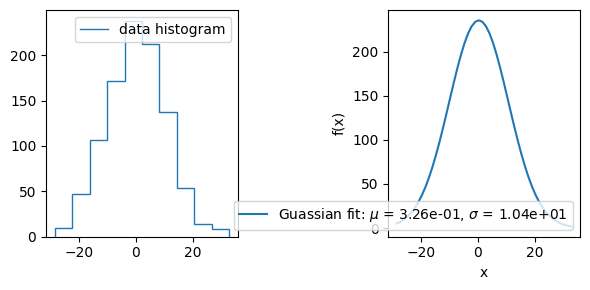

In [7]:
def normal(x,mu,sigma,a):
    return a * np.exp(-(x-mu)**2 / (2*sigma**2))

f = [random.normalvariate(mu=0,sigma=10) for n in range(1000)] # random data
counts, bins = np.histogram(f,bins=10) # histogram
bincenters = (bins[:-1] + bins[1:])/2 # center of bins

x_fit = np.linspace(np.amin(bins),np.amax(bins)) # range in 'x' to fit data
popt, pcov = curve_fit(normal, bincenters, counts) # fit the data

fit_label = "Guassian fit: $\mu$ = {:.2e}, $\sigma$ = {:.2e}".format(popt[0],popt[1])  

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3), dpi=100)

axes[0].stairs(counts, bins,label='data histogram')
axes[0].legend()

axes[1].plot(x_fit, normal(x_fit,*popt),label=fit_label)
axes[1].legend(loc='lower right')
axes[1].set_xlabel('x')
axes[1].set_ylabel('f(x)')
fig.tight_layout()

### Problem 2: Dampled Motion
The one-dimensional position $y(x)$ (in metres) for a particle undergoing damped oscillatory motion can be represented as 

$$ y(t) = Ae^{-\alpha t}\cos({\omega t - \phi})$$ 

Simulate the motion of a particle with the equation above in time for $t \in [0,1] \text{ s}$, with a frequency between $10$ and $20 \text{ Hz}$ ($\omega = 2\pi f$) and a damping factor $\alpha = 10 / \text{s}$. Perform discrete FFT and extract the rotation frequency. Use an appropriate sampling rate!

BONUS: Add Gaussian noise to the poisiton from a distribution where $\mu = 0$ and $\sigma = 0.01$

Peak found at 2.00e+01 Hz


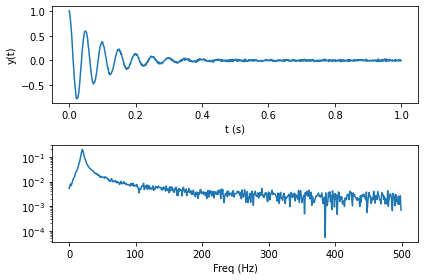

In [13]:
dt = 0.001
t = np.arange(0,1,dt)
y = [np.exp(-10*t)*np.cos(2*np.pi*20*t) + random.gauss(mu=0,sigma=0.01) for t in t]

fft_y = fft(y)
t_fft = fftfreq(len(t), dt)[:len(t)//2]
mod_F = abs(fft_y[0:len(t)//2])*2/len(t_fft)

fig, axes = plt.subplots(2)

axes[0].plot(t,y)
axes[0].set_ylabel('y(t)')
axes[0].set_xlabel('t (s)')

axes[1].semilogy(t_fft, mod_F, label = 'FFT')
axes[1].set_xlabel('Freq (Hz)')
fig.tight_layout()

peaks = signal.find_peaks(mod_F,height=1e-1) # add height threshold to isolate peak
peak_freqs = t_fft[peaks[0]]
for freq in peak_freqs:
    print('Peak found at {:.2e} Hz'.format(freq))